In [35]:
import time
import os
import cv2
import matplotlib.pyplot as plt
from lib.utilities import *
import numpy as np
import pandas as pd
import math

In [3]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
cell_type_prefix = 'pv'
plt.rcParams.update({'font.size': 13})
#plt.rcParams['figure.figsize'] = [20, 12]

In [25]:
kate_pv_file = data_dir + '/Kate\'s/Kate-reanalysis-modular.csv'
csv_columns = ['Date',
             'Rec',
             'Stim Loc',
               'Genotype',
               'Sex',
               'Age',
             'L2/3 A Latency',
               'L4 A Latency',
               'L5 A Latency',
               'L2/3 B Latency',
               'L4 B Latency',
               'L5 B Latency',
               'L2/3 C Latency',
               'L4 C Latency',
               'L5 C Latency',
               'L2/3 D Latency',
               'L4 D Latency',
               'L5 D Latency',
               'L2/3 E Latency',
               'L4 E Latency',
               'L5 E Latency',
             ]
def parse_latency_with_parens(v):
    """ return either [latency1] or [latency1, latency2]"""
    if type(v) in [float, int]:
        return [v]
    try:
        v = float(v)
        return [v]
    except Exception as e:
        pass
    if "(+" not in v:
        return [None]
    v = v.split("(")
    v[1] = v[1].replace(")", '').replace("+", '')
    v = [float(x) for x in v]
    v[1] += v[0]
    return v

In [5]:
print(parse_latency_with_parens('50.1126 (+4.3)'))
print(parse_latency_with_parens('50.112'))

[50.1126, 54.4126]
[50.112]


In [6]:
# load the CSV
df = pd.read_csv(kate_pv_file)
df = pd.DataFrame(df)
df

,Date,Rec,Genotype,Age,Sex,Stim Loc,L2/3 A Latency,L4 A Latency,L5 A Latency,L2/3 B Latency,...,L5 B Latency,L2/3 C Latency,L4 C Latency,L5 C Latency,L2/3 D Latency,L4 D Latency,L5 D Latency,L2/3 E Latency,L4 E Latency,L5 E Latency
0,1/11/2020,09_01_01,FXR1,53,F,L2/3 B,54.8205,54.5535,54.862,53.9293,...,54.5751,54.271,53.8947,NaN,54.0786,NaN,NaN,NaN,NaN,NaN
1,1/18/2021,04_01_02,PV,49,M,L2/3 C,53.8029,53.8811,NaN,53.3963,...,NaN,49.8387 (+3.5),53.3491,53.7246,53.44,53.6922,53.6004,54.2031,53.8515,54.6566
2,1/18/2021,05_01_03,PV,49,M,L2/3 B,52.8377,52.9616,53.486,52.8154,...,53.396,53.6586,53.6076,53.6134,NaN,NaN,NaN,NaN,NaN,NaN
3,1/18/2021,07_01_02,PV,49,M,L2/3 C,52.8154,52.8366,53.396,54.5388,...,54.649,54.0642,54.0226,54.4297,50.4106 (+4),52.1609,52.7517,51.1995,53.5592,54.0431
4,1/19/2021,05_01_01,PV,50,F,L2/3 A,51.3762 (+4.8),54.6994,54.7604,55.1393,...,55.0929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,12/28/2020,08_01_04,FXR1,45,F,L4 A,53.0776,50.4254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,12/29/2020,04_01_01,FXR1,46,F,L4 B,NaN,53.3985,63.6236,53.3501,...,53.1769,53.7183,53.1548,53.4307,NaN,53.5447,53.6649,NaN,NaN,NaN
63,12/29/2020,06_01_01,FXR1,46,F,L4 B,53.6919,52.6099,52.7603,53.2858,...,52.5961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,12/29/2020,07_01_03,FXR1,46,F,L4 B,53.6564,54.1688,NaN,53.2094,...,54.1532,53.2611,51.6339,53.0609,53.813,NaN,NaN,NaN,NaN,NaN


In [7]:
# campare:
#   count probability of double spiking based on layer
#   interlaminar by direction (L2/3 -> L5 vs L5 -> L2/3)
#   count probability of crossing layer or barrel
#   Latency of second activation



Stim Loc: L2/3
	L2/3 doubles: 55 of responsive 109 
	L4 doubles: 21 of responsive 115 
	L5 doubles: 2 of responsive 67
[109, 115, 67]
[0.06803851823023543, 0.03984848430396382, 0.021107665110046196]

Stim Loc: L4
	L2/3 doubles: 5 of responsive 32 
	L4 doubles: 9 of responsive 43 
	L5 doubles: 2 of responsive 33
[32, 43, 33]
[0.06987712429686843, 0.06976744186046512, 0.04285495643554834]

Stim Loc: L5
	L2/3 doubles: 2 of responsive 49 
	L4 doubles: 2 of responsive 64 
	L5 doubles: 1 of responsive 62
[49, 64, 62]
[0.02886150127292031, 0.02209708691207961, 0.016129032258064516]
average delay of double: 3.673737373737373 +/- 0.593327521011003


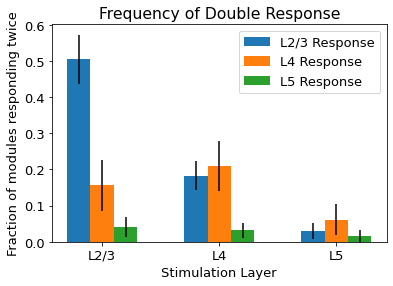

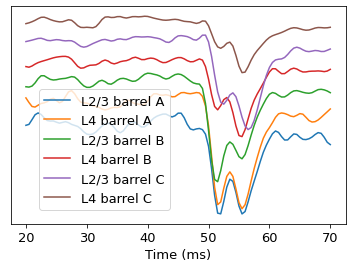

In [86]:
#   count probability of double spiking based on stim layer
double_data = {}
total_data = {}
errbars_data = {}
response_delays = []
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Loc'].str.contains(stim_loc)]
    print("\nStim Loc:", stim_loc)
    layer_double_cts = [0, 0, 0]
    layer_single_cts = [0, 0, 0]
    for col in csv_columns:
        if 'Latency' in col:
            col_double_ct = 0
            col_single_ct = 0
            for row in df2[col]:
                latencies = parse_latency_with_parens(row)
                if len(latencies) == 2:
                    response_delays.append(latencies[1] - latencies[0])
                    col_double_ct += 1
                if len(latencies) == 1 and not (latencies[0] is None or math.isnan(latencies[0])):
                    col_single_ct += 1
                                                
            for i in range(3):
                sl = ['L2/3', 'L4', 'L5'][i]
                if sl in col:
                    layer_double_cts[i] += col_double_ct
                    layer_single_cts[i] += col_single_ct
                    break
                    
                    
    print("\tL2/3 doubles:", layer_double_cts[0], "of responsive", layer_single_cts[0] + layer_double_cts[0],
          "\n\tL4 doubles:", layer_double_cts[1], "of responsive", layer_single_cts[1] + layer_double_cts[1],
          "\n\tL5 doubles:", layer_double_cts[2], "of responsive", layer_single_cts[2] + layer_double_cts[2])
    errbars = [layer_single_cts[i] + layer_double_cts[i] for i in range(3)]
    total_data[stim_loc] = [x for x in errbars]
    errbars_data[stim_loc] = [np.sqrt(layer_double_cts[j]) / 
                              errbars[j] for j in range(len(layer_double_cts))]
    double_data[stim_loc] = [layer_double_cts[j] / 
                             errbars[j] for j in range(len(layer_double_cts))]
    print(errbars)
    print(errbars_data[stim_loc])
    
print("average delay of double:", np.mean(response_delays), "+/-", np.std(response_delays))
    
# plot this as bars 
plt.clf()
i = 0
for nm in double_data:
    x = np.arange(3)
    if i == 1:
        plt.bar(x + (i-1) * 0.2, 
                double_data[nm],
                0.2,
                label=nm + " Response",
                tick_label=['L2/3', #\n(n='+str(total_data[nm][0])+')', 
                            'L4', #\n(n='+str(total_data[nm][1])+')', 
                            'L5']) #\n(n='+str(total_data[nm][2])+')'])
    else:
        plt.bar(x + (i-1) * 0.2, 
                double_data[nm],
                0.2,
                label=nm + " Response")
    plt.errorbar(x + (i-1) * 0.2, 
                double_data[nm],
                yerr=errbars_data[nm],
                fmt='none',
                color='black')
    i += 1
    
plt.title("Frequency of Double Response")
plt.xlabel("Stimulation Layer")
plt.ylabel("Fraction of modules responding twice")
#plt.xticks(rotation='vertical')
plt.legend()#bbox_to_anchor=(0.55, 1.05), loc='upper center')
plt.savefig(data_dir + "results_double_prelim_7-19-23.png")
plt.show()

plt.clf()
traces = pd.read_csv(data_dir + "/05-25-21/selected_zda/Traces_05_01_04.dat",
                         sep='\t',
                         header=0,
                         names=['Index',  '1',  '2',  '3', '4', '5',
                               '6','7','8', '9'])
start_cut = 40
end_cut = 140
baseline = 17
v1 = traces.loc[start_cut:end_cut, ["1"]]
v2 = traces.loc[start_cut:end_cut, ["2"]] 
v3 = traces.loc[start_cut:end_cut, ["3"]] 
v4 = traces.loc[start_cut:end_cut, ["4"]] 
v5 = traces.loc[start_cut:end_cut, ["5"]] 
v6 = traces.loc[start_cut:end_cut, ["6"]] 
t = [(i+start_cut) * 0.5 for i in range(len(v1))]
plt.plot(t, v3, label="L2/3 barrel A")
plt.plot(t, v4+1, label="L4 barrel A")
plt.plot(t, v1+2, label="L2/3 barrel B")
plt.plot(t, v2+3, label="L4 barrel B")
plt.plot(t, v5+4, label="L2/3 barrel C")
plt.plot(t, v6+5, label="L4 barrel C")
plt.legend(bbox_to_anchor=(0.28, 0.65), loc='upper center')
plt.xlabel("Time (ms)")
plt.yticks([])
plt.savefig(data_dir + "/traces_doubles_7-19-23.png")
plt.show()